# Simple returns vs Log returns & Normality Assumption
*If we want to model returns using the normal distribution:*
1.  Simple returns:  The product of normally distributed variables is NOT normally distributed
2.  Log returns: The sum of normally distributed variables DOES follow a normal distribution.

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import pylab
import seaborn as sns
import scipy.stats as stats

# from pandas_datareader import data as pdr
import  pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()

import plotly.offline as pyo # interactive plot
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected= True) # this is not in notebook, how to modify this part?
pd.options.plotting.backend = 'plotly'
import plotly.io as pio 
pio.renderers.default = "colab"

In [ ]:
# Get the stocks data
start = dt.datetime(2018, 1, 1)
end = dt.datetime.now()

df = web.get_data_yahoo('AAPL', start, end)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.888062,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.880947,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.070839,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.538441,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.384163,82271200


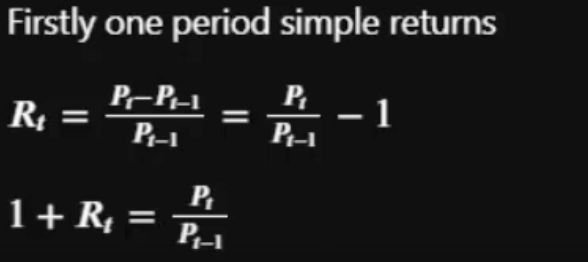

In [ ]:
 simple_returns = df.Close.pct_change().dropna()
 simple_returns

Date
2018-01-03   -0.000174
2018-01-04    0.004645
2018-01-05    0.011385
2018-01-08   -0.003714
2018-01-09   -0.000115
                ...   
2023-03-08    0.008377
2023-03-09   -0.014915
2023-03-10   -0.013879
2023-03-13    0.013266
2023-03-14    0.014089
Name: Close, Length: 1307, dtype: float64

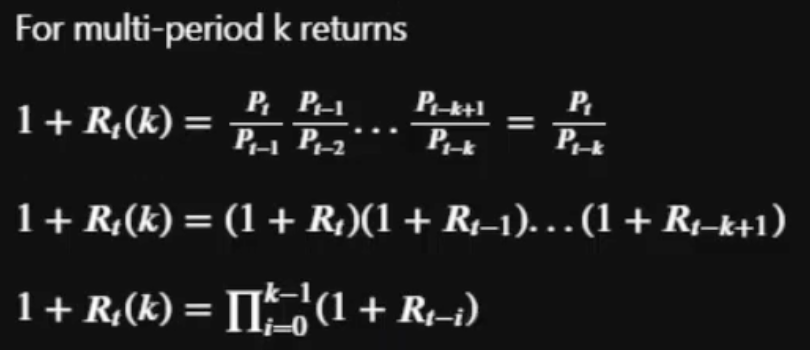

In [ ]:
df.Close.plot() #.update_layout(autosize = False, width = 1400, height = 600)

In [ ]:
print('First', df.Close[0], 'Last', df.Close[-1])

First 43.064998626708984 Last 152.58999633789062


In [ ]:
simple_returns.mean()

0.0011876224984275832

In [ ]:
# If we use mean to reach the last day's price, we will get a higher price.
# Only use means can't describe a lot of stuff by itself.
# Since we dropped NA, therefore, the len(simple_returns) = total period length - 1 = k - 1
# At this formula, the simple_returns.mean() = Rt. Because we want to calculate the increase of the price in this period.

df.Close[0] * (1 + simple_returns.mean()) ** len(simple_returns)

203.1637243117087

In [ ]:
# Therefore, lets take the formula
df.Close[0] * np.prod([(1 + Rt) for Rt in simple_returns]) # Since we generate a new list, which used '[]', and then use np.prod to calculate the value.

152.58999633789117

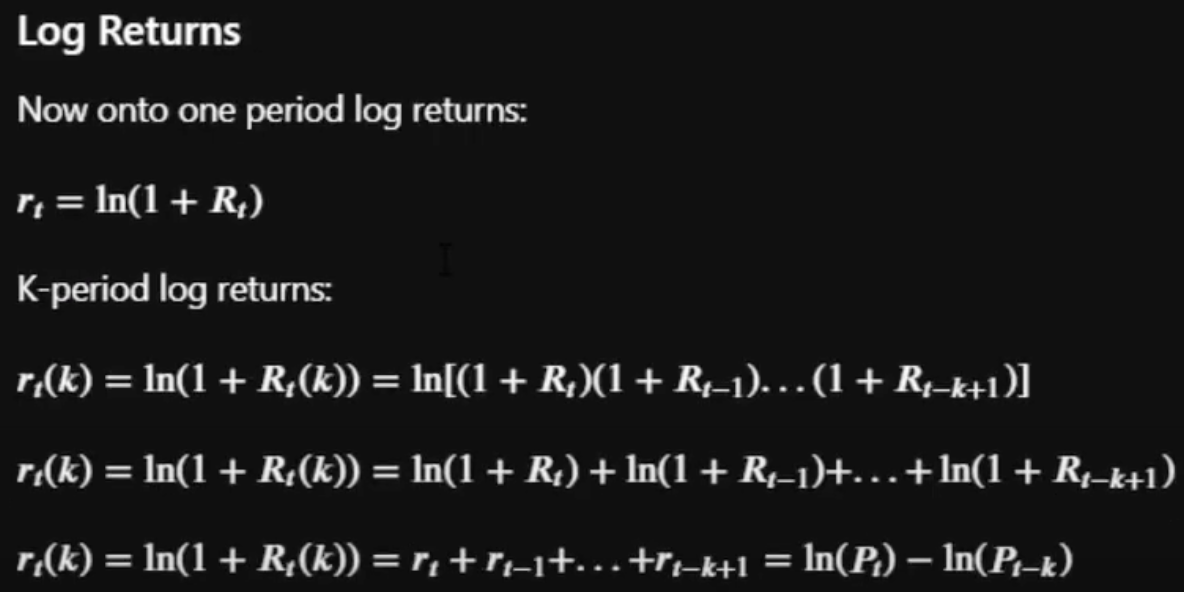

In [ ]:
log_returns = np.log(df.Close/df.Close.shift(1)).dropna()
log_returns

Date
2018-01-03   -0.000174
2018-01-04    0.004634
2018-01-05    0.011321
2018-01-08   -0.003721
2018-01-09   -0.000115
                ...   
2023-03-08    0.008342
2023-03-09   -0.015027
2023-03-10   -0.013976
2023-03-13    0.013179
2023-03-14    0.013991
Name: Close, Length: 1307, dtype: float64

In [ ]:
log_returns.mean()

0.0009678989988918431

In [ ]:
df.Close[0] * np.exp(log_returns.mean() * len(log_returns)) # Need time to understand this part.

152.58999633789114

The log distribution bounds our stock price at 0. Which is a nice property to have and is consistent with reality.
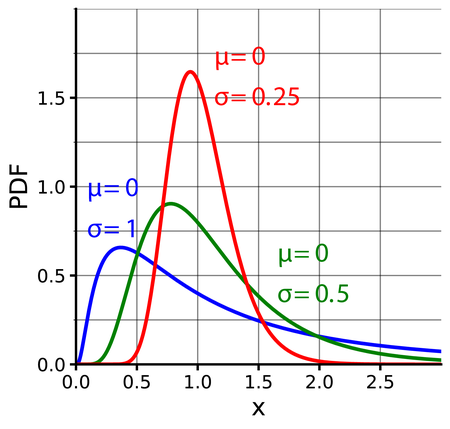

In [ ]:
# Histogram og log returns
log_returns.plot(kind = 'hist').update_layout(autosize = False, width = 1200, height = 600)

Fat tails

In [ ]:
# Assumption in normal distribution

log_returns_sorted = log_returns.tolist()
log_returns_sorted.sort()
worst = log_returns_sorted[0]
best = log_returns_sorted[-1]

std_worst = (worst - log_returns.mean()) / log_returns.std()
std_best = (best - log_returns.mean()) / log_returns.std()

print('Std dev. worst %.2f  best %.2f' %(std_worst, std_best))
print('Probability worst %.10f  best %.10f' %(stats.norm(0,1).pdf(std_worst), stats.norm(0,1).pdf(std_best)))

Std dev. worst -6.62  best 5.35
Probability worst 0.0000000001  best 0.0000002373


## Testing for Normality

Financial data is not normally distributed.

And how could we actually proving this?

1. Visually 
2. Numerically -> Hypothesis tesing & statistical inference

Q-Q Plot


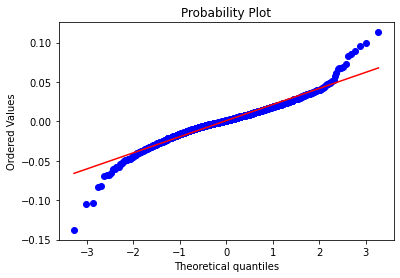

In [ ]:
# Visual -> 1. Histogram 2. Q-Q or Quantile-Quantile Plots (QQ plot, did the same thing in R)
stats.probplot(log_returns, dist = 'norm', plot = pylab)
print('Q-Q Plot')

At the tails, the data starts to deviating away from the normal distribution line.

In [ ]:
# Box Plots
log_returns.plot(kind = 'box').update_layout(autosize = False, width = 800, height = 500)

We've got a very heavy tails to either side. So maybe we don't have a normally distributed data.

### Hypothesis Testing

Kolmogorov Smirnov test

The KS Test computes the distance between the empirical distribution and the theoretical distribution and defines the test statistic as the supremum of the set of those distances.

The Test Statistic of the KS Test follows a Kolmogorov distribution if the null hypothesis is true. If the observed data perfectly follow a normal distribution, the value of the KS statistic will be 0. The P-value is used to decide whether the difference is large enough to reject the null hypothesis.

This approach could be used to any distribution not only the normal distribution.


In [ ]:
ks_stat, p_value = stats.kstest(log_returns, 'norm')
print(ks_stat, p_value)

#Threshold
if p_value > 0.05:
  print('Probably Guassian')
else:
  print('Probably NOT Guassian')

0.46913811495041713 2.6479441356521576e-264
Probably NOT Guassian


In [ ]:
# Shapiro Wilk test
# This test is the most powerful test when testing for a normal distribution. 
#It has been developed specifically for the normal distribution and it cannot be used for testing against other distributions like for example the KS test.

In [ ]:
sw_stat, p_value = stats.shapiro(log_returns)
print(sw_stat, p_value)

#Threshold
if p_value > 0.05:
  print('Probably Guassian')
else:
  print('Probably NOT Guassian')

0.9499289393424988 1.0949018183323632e-20
Probably NOT Guassian


In [ ]:
# However, if we just take three months dats, the date probably is normally distributed in this time range.